# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [34]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [11]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
num_iter=1000
for lr in learning_rates:
    for rg in regularization_strengths:
        svm=LinearSVM()
        svm.train(X_train_feats, y_train, lr, rg, num_iter)
        tr_acc=np.mean(svm.predict(X_train_feats)==y_train)
        va_acc=np.mean(svm.predict(X_val_feats)==y_val)
        results[(lr,rg)]=(tr_acc,va_acc)
        if(va_acc>best_val):
            best_val=va_acc
            best_svm=svm
        

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.100980 val accuracy: 0.104000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.088755 val accuracy: 0.086000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.291694 val accuracy: 0.299000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.110673 val accuracy: 0.108000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.413408 val accuracy: 0.417000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.398898 val accuracy: 0.395000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.413959 val accuracy: 0.412000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.403531 val accuracy: 0.399000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.333796 val accuracy: 0.368000
best validation accuracy achieved during cross-validation: 0.417000


In [12]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.415


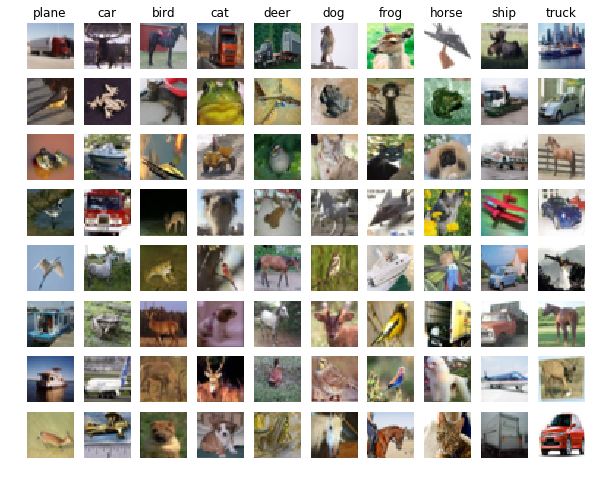

In [13]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

### Answer:
        The result is not satisfactory because it mess up with many wrong classifications.


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [5]:
print(X_train_feats.shape)

(49000, 155)


In [49]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_acc=0.0
num_classes = 10

hidden_size=[500]
learning_rate = [0.3]#, 0.25, 0.30 ]
reg = [ 0.00005]#, 0.00001, 0.000005 ]

for lr in learning_rate:
    for rg in reg:
        for hd in hidden_size:    
            net = TwoLayerNet(input_dim, hd, num_classes)
            # Train the network
            stats1 = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=2000, batch_size=500,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=rg, verbose=True)
            yv_pred=net.predict(X_val_feats)
            yv_acc=np.mean(yv_pred== y_val)
            print('lr:%f,rg:%f,hd:%f,accuracy:%f'%(lr,rg,hd,yv_acc))
            if(best_acc<yv_acc):
                best_acc=yv_acc
                best_net=net
print('best accuracy:', best_acc) 

iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 1.762807
iteration 200 / 2000: loss 1.402732
iteration 300 / 2000: loss 1.387242
iteration 400 / 2000: loss 1.310745
iteration 500 / 2000: loss 1.252081
iteration 600 / 2000: loss 1.301795
iteration 700 / 2000: loss 1.186253
iteration 800 / 2000: loss 1.194687
iteration 900 / 2000: loss 1.136654
iteration 1000 / 2000: loss 1.092262
iteration 1100 / 2000: loss 1.151227
iteration 1200 / 2000: loss 1.046707
iteration 1300 / 2000: loss 1.132667
iteration 1400 / 2000: loss 1.110323
iteration 1500 / 2000: loss 1.009587
iteration 1600 / 2000: loss 1.081306
iteration 1700 / 2000: loss 1.047085
iteration 1800 / 2000: loss 0.946019
iteration 1900 / 2000: loss 1.033370
lr:0.300000,rg:0.000050,hd:500.000000,accuracy:0.589000
best accuracy: 0.589


In [50]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.59


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# ※   Laplacian of Gaussian (LoG)
         Edge can also be regarded as a good feature of the image.Laplacian operator's strength lies in egde detection. However,a successful edge detection need to decrease the sensitivity of noises.Since laplace operator may detect edges as well as noise,we choose to use the LoG operateor so as to  smooth the image first by a convolution with a Gaussian kernel before laplace operator applied.


In [14]:
#coding=utf-8 
import numpy as np
from PIL import Image
from cs231n.features import *
from scipy import ndimage

def log_feature(im):
    """Compute Laplace of Guassian (LOG) feature for an image  
    Parameters:
      im : an input grayscale or rgb image
      
    Returns:
      feat: Histogram of Gradient (LOG) feature
        
    """
    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.at_least_2d(im)
   # convert rgb to grayscale if needed
    sx, sy = image.shape # image size
    feat=ndimage.gaussian_laplace(image, sigma=2)
    return feat.ravel()

In [16]:
num_color_bins=10
feature_fns = [log_feature]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)    
# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])
 


Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [19]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_acc=0.0
num_classes = 10

hidden_size=[500]
learning_rate = [0.2]#, 0.25, 0.30 ]
reg = [ 0.000005 ]
for lr in learning_rate:
    for rg in reg:
        for hd in hidden_size:    
            net = TwoLayerNet(input_dim, hd, num_classes)
            # Train the network
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1000, batch_size=500,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=rg, verbose=True)
            yv_pred=net.predict(X_val_feats)
            yv_acc=np.mean(yv_pred== y_val)
            print('lr:%f,rg:%f,hd:%f,accuracy:%f'%(lr,rg,hd,yv_acc))
            if(best_acc<yv_acc):
                best_acc=yv_acc
                best_net=net
print('best accuracy:', best_acc)

iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.106270
iteration 200 / 2000: loss 1.850766
iteration 300 / 2000: loss 1.752721
iteration 400 / 2000: loss 1.605567
iteration 500 / 2000: loss 1.478790
iteration 600 / 2000: loss 1.485877
iteration 700 / 2000: loss 1.325873
iteration 800 / 2000: loss 1.350412
iteration 900 / 2000: loss 1.272807
iteration 1000 / 2000: loss 1.213678
iteration 1100 / 2000: loss 1.219039
iteration 1200 / 2000: loss 1.303034
iteration 1300 / 2000: loss 1.219528
iteration 1400 / 2000: loss 1.218877
iteration 1500 / 2000: loss 1.129628
iteration 1600 / 2000: loss 1.200889
iteration 1700 / 2000: loss 1.098080
iteration 1800 / 2000: loss 1.095513
iteration 1900 / 2000: loss 1.062183
lr:0.250000,rg:0.000005,hd:500.000000,accuracy:0.475000
best accuracy: 0.475


In [20]:
test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.498


# Conclusion:
        As the result shows,after modification,the best test accuracy which about 50% is still not as good as the Hog + Histogram method.It is because that the LoG feature can be sensitve to many factors like scale and rotation.Hence the LoG feature may not be suitable for classification.

# ※   SIFT feature
    Scale-invariant feature transform (SIFT) could detect and describe local features in images.The match of the image makes full use of comparing each feature from the new image to this database and finding candidate matching features based on Euclidean distance of their feature vectors.
  

In [58]:
import cv2

def sift_features(im):
################################
#this function just return the first 10
#feature vector for the sift detector
##############################
    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.at_least_2d(im)
    image=np.array(im, dtype=np.uint8)
    key_point=10
    gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    if len(kp)>=key_point:
        des=des[0:key_point,:]
    elif len(kp)==0 :
        des=np.zeros((key_point,128),dtype=np.uint8)
    else:
        des=np.vstack((des,np.ones((key_point-len(kp),128),dtype=np.uint8)))
    return des.ravel()
    


num_color_bins=10
feature_fns = [sift_features]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)    
# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])
 


Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [59]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_acc=0.0
num_classes = 10

hidden_size=[500]
learning_rate = [0.30]#, 0.25, 0.30 ]
reg = [ 0.00001 ]
for lr in learning_rate:
    for rg in reg:
        for hd in hidden_size:    
            net = TwoLayerNet(input_dim, hd, num_classes)
            # Train the network
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=2000, batch_size=500,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=rg, verbose=True)
            yv_pred=net.predict(X_val_feats)
            yv_acc=np.mean(yv_pred== y_val)
            print('lr:%f,rg:%f,hd:%f,accuracy:%f'%(lr,rg,hd,yv_acc))
            if(best_acc<yv_acc):
                best_acc=yv_acc
                best_net=net
print('best accuracy:', best_acc)

iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.132349
iteration 200 / 2000: loss 1.990668
iteration 300 / 2000: loss 1.888383
iteration 400 / 2000: loss 1.899707
iteration 500 / 2000: loss 1.729396
iteration 600 / 2000: loss 1.619056
iteration 700 / 2000: loss 1.600349
iteration 800 / 2000: loss 1.413919
iteration 900 / 2000: loss 1.411815
iteration 1000 / 2000: loss 1.225098
iteration 1100 / 2000: loss 1.091870
iteration 1200 / 2000: loss 1.042314
iteration 1300 / 2000: loss 0.891897
iteration 1400 / 2000: loss 0.775401
iteration 1500 / 2000: loss 0.675394
iteration 1600 / 2000: loss 0.566887
iteration 1700 / 2000: loss 0.477942
iteration 1800 / 2000: loss 0.402424
iteration 1900 / 2000: loss 0.353903
lr:0.300000,rg:0.000010,hd:500.000000,accuracy:0.267000
best accuracy: 0.267


# Conclusion
   From the accuracy we can conclude that the simple way to just pass feature vector doesn't works well.Therefore,we need more complicated method to record the vector info.Due to time constraints,there are still new methods to explore for the nerual network sift classification.For instance,I have noticed a paper mentions *bag-of-words model (BoW model)* to record the local feature extract by sift algorithm.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!

# ※   Optimization for Stochastic Gradient Descent ----*Momentum*
        The standard SGD might tend to oscillate across the narrow ravine since the negative gradient will point down one of the steep sides rather than along the ravine towards the optimum thus standard SGD can lead to very slow convergence particularly compared with the initial steep gains. 
        Momentum is a method for accelerating the decrease along the shallow ravine. The momentum update the object not only by the current gradient but also using the previous gradients.

In [55]:
best_net = None # store the best model into this 
best_acc=0.0

input_size = X_train_feats.shape[1]
num_classes = 10

learning_rate= [0.5]
hidden_size=[500]
reg= [0.00001,]

############################################################
#We design the train1(...) function to optimize the SGD method
#and set the coefficient alpha as 0.9 which determines for how many 
#iterations the previous gradients are incorporated into the current update.
#(like the weight of th previous gradients when calculating result gradient)
#the expression is shown below:
#v(t)=alpha* v(t-1) + learning_rate * gradient(t-1)
#update_value(t) -= v(t)
###########################################################

for lr in learning_rate:
    for rg in reg:
        for hd in hidden_size:    
            net = TwoLayerNet(input_size, hd, num_classes)
            # Train the network
            stats = net.train1(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=2000, batch_size=500,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=rg, verbose=True)
            yv_pred=net.predict(X_val_feats)
            yv_acc=np.mean(yv_pred== y_val)
            print('ls:%f,rg:%f,hd:%f,accuracy:%f'%(lr,rg,hd,yv_acc))
            if(best_acc<yv_acc):
                best_acc=yv_acc
                best_net=net
print('best accuracy:', best_acc)               
            



iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 1.338665
iteration 200 / 2000: loss 1.042983
iteration 300 / 2000: loss 1.179240
iteration 400 / 2000: loss 0.963972
iteration 500 / 2000: loss 0.957253
iteration 600 / 2000: loss 0.883880
iteration 700 / 2000: loss 0.721614
iteration 800 / 2000: loss 0.750404
iteration 900 / 2000: loss 0.667905
iteration 1000 / 2000: loss 0.567190
iteration 1100 / 2000: loss 0.560617
iteration 1200 / 2000: loss 0.532508
iteration 1300 / 2000: loss 0.500924
iteration 1400 / 2000: loss 0.392405
iteration 1500 / 2000: loss 0.324027
iteration 1600 / 2000: loss 0.295666
iteration 1700 / 2000: loss 0.243166
iteration 1800 / 2000: loss 0.216622
iteration 1900 / 2000: loss 0.168202
ls:0.500000,rg:0.000010,hd:500.000000,accuracy:0.559000
best accuracy: 0.559


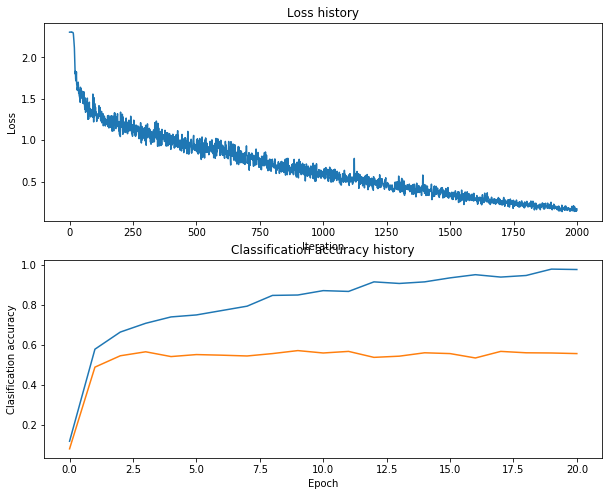

In [57]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [56]:
test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.555


# Comparsion with the original SGD

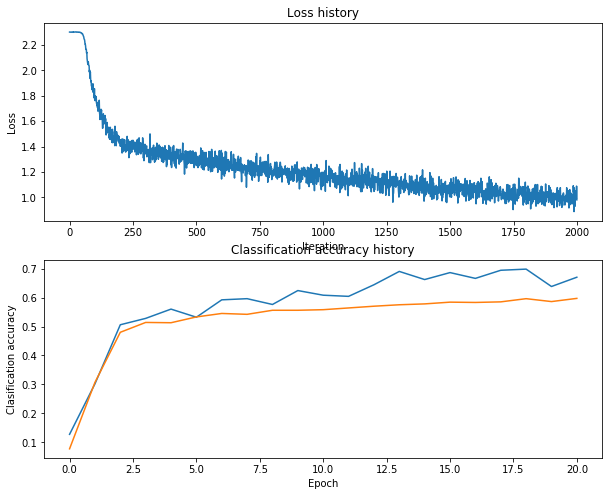

In [51]:
# Plot the loss function and train / validation accuracies
#plot the original SGD method(which store in the stats1 array)
plt.subplot(2, 1, 1)
plt.plot(stats1['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats1['train_acc_history'], label='train')
plt.plot(stats1['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

### Conclusion
    The result shows that the oscillation of the original SGD is more severe than the SGD+Momentum and the velocity of convergence is also slow than the SGD+Momentum method.Beside,the final training loss of the SGD+Momentum is smaller than the original one. However,as for the final test accuracy,the SGD+Momentum has subtle inferior to the original one.